In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Here, We are using FER-2013 dataset which has** 48x48 pixels grey-scale** images of face with 7 different emotions lable. The 7-different emotions are- *0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral*

In [21]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D,BatchNormalization, LSTM, CuDNNLSTM, MaxPooling2D
from keras.models import Sequential
from keras import regularizers
import keras

from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D


from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import matplotlib.pyplot as plt
import cv2

In [23]:
image_generator = ImageDataGenerator(rescale = 1./255)
training_set = image_generator.flow_from_directory(batch_size=128,
                                                 directory='../input/fer2013/train',
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                )

testing_set = image_generator.flow_from_directory(batch_size=64,
                                                 directory='../input/fer2013/test',
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                 )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [24]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [25]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        '../input/fer2013/train',
        target_size=(48, 48),
        batch_size=64,
#         color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        '../input/fer2013/test',
        target_size=(48, 48),
        batch_size=64,
#         color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [26]:
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 3)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, decay=1e-6), metrics=['accuracy'])

# Train the neural network/model
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
448/448 [==============================] - 154s 343ms/step - loss: 1.7205 - accuracy: 0.3040 - val_loss: 1.4985 - val_accuracy: 0.4247
Epoch 2/50
448/448 [==============================] - 154s 344ms/step - loss: 1.4289 - accuracy: 0.4461 - val_loss: 1.2999 - val_accuracy: 0.4986
Epoch 3/50
448/448 [==============================] - 153s 342ms/step - loss: 1.2810 - accuracy: 0.5099 - val_loss: 1.1981 - val_accuracy: 0.5389
Epoch 4/50
448/448 [==============================] - 154s 343ms/step - loss: 1.2019 - accuracy: 0.5413 - val_loss: 1.1497 - val_accuracy: 0.5547
Epoch 5/50
448/448 [==============================] - 154s 343ms/step - loss: 1.1462 - accuracy: 0.5640 - val_loss: 1.1384 - val_accuracy: 0.5586
Epoch 6/50
448/448 [==============================] - 153s 341ms/step - loss: 1.1078 - accuracy: 0.5814 - val_loss: 1.1119 - val_accuracy: 0.5698
Epoch 7/50
448/448 [==============================] - 154s 343ms/step - loss: 1.0582 - accuracy: 0.5970 - val_loss: 1.1016 -

In [32]:
hist = emotion_model_info.history

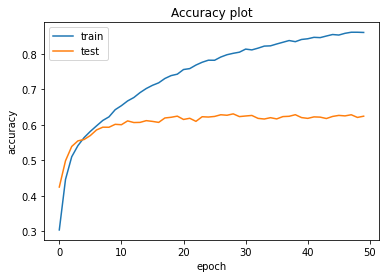

In [33]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("emotion_model_accuracy.png")

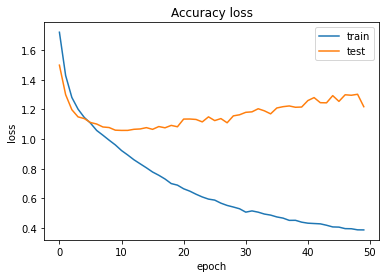

In [34]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("emotion_model_loss.png")

In [ ]:
predicted_test_labels = np.argmax(emotion_model.predict(testing_set), axis=1)
test_labels = np.argmax(testing_set, axis=1)
print ("Accuracy score = ", accuracy_score(test_labels, predicted_test_labels))